# 从线性回归说起

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

## 提出问题


在DOTA2中，一名选手的对线能力和打钱能力有什么关系？如果用前6分钟正补数表示对线能力，GPM表示打钱能力，那平均来说，前6分钟每多一个正补，GPM能增加多少？

类比问题：平均来说，每多接受一年教育，就业后的月薪会增加多少？

完美的方法是设计并实施随机实验，但这些问题都几乎不能通过实验来解决，比如按出事时的身份证号随机分配，来安排你这辈子接受几年教育？

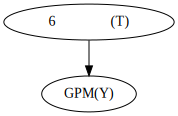

In [3]:
g = gr.Digraph()
g.edge("前6分钟正补数(T)", "GPM(Y)")
g

## Confounding Bias（混杂偏倚）

A confounding variable is one that causes both the treatment and the outcome.

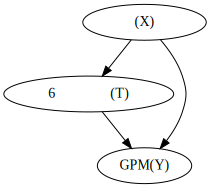

In [4]:
g = gr.Digraph()
g.edge("前6分钟正补数(T)", "GPM(Y)")
g.edge("天梯段位(X)", "前6分钟正补数(T)")
g.edge("天梯段位(X)", "GPM(Y)")
g

## 线性回归

In [5]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parents[0]))
from utils import get_db_engine, get_hero_sample_match, parallel_run_api
import pandas as pd

dota2_hero_df = pd.read_sql("select * from hero", con=get_db_engine())
dota2_hero_id_to_name = { str(r['hero_id']): r['hero_name'] for _, r in dota2_hero_df.iterrows() }
dota2_hero_name_to_id = { r['hero_name']: str(r['hero_id']) for _, r in dota2_hero_df.iterrows() }
dota2_hero_df.head(1)

,hero_id,ingame_name,en_official_name,primary_attr,attack_type,roles,legs,en_name,hero_name
0,1,npc_dota_hero_antimage,Anti-Mage,agi,Melee,"{Carry,Escape,Nuker}",2,antimage,敌法师


In [8]:
pa_df = pd.read_sql("select * from hero_pa_sample_info", con = get_db_engine())
pa_df.head(1)

,match_id,hero_id,duration,rank_tier,party_id,party_size,creeps_stacked,camps_stacked,kills,deaths,assists,gold_per_min,total_gold,randomed,repicked,camp,hero_name,lane_role,6_min_last_hits
0,6286701460,48,2057,55.0,0,1,4,2,4,5,14,573,19644,False,None,radiant,露娜,safe,28


In [24]:
# pa_df.to_csv("hero_pa_sample_info.csv", index=False, encoding="utf_8_sig")
pa_df = pd.read_csv("hero_pa_sample_info.csv")
pa_df = pa_df[pa_df["hero_id"].astype(str) == dota2_hero_name_to_id["幻影刺客"]]
pa_df = pa_df.rename(columns = {"6_min_last_hits": "the_6_min_last_hits"})
pa_df

,match_id,hero_id,duration,rank_tier,party_id,party_size,creeps_stacked,camps_stacked,kills,deaths,assists,gold_per_min,total_gold,randomed,repicked,camp,hero_name,lane_role,the_6_min_last_hits
7,6286701460,44,2057,NaN,7,1,0,0,6,2,5,619,21221,False,NaN,dire,幻影刺客,safe,27
19,6287165562,44,2518,NaN,4,1,0,0,13,8,4,616,25851,False,NaN,dire,幻影刺客,safe,37
22,6286882818,44,1812,NaN,1,3,2,1,2,10,4,361,10902,False,NaN,radiant,幻影刺客,safe,12
39,6285935392,44,2681,41.0,9,1,0,0,6,4,8,500,22341,False,NaN,dire,幻影刺客,safe,24
46,6286572453,44,1779,NaN,6,1,0,0,6,6,8,414,12275,False,NaN,dire,幻影刺客,safe,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99428,6286422635,44,4008,NaN,5,1,0,0,15,14,23,745,49766,False,NaN,dire,幻影刺客,safe,16
99435,6286313201,44,3610,NaN,1,5,0,0,14,15,18,491,29541,False,NaN,dire,幻影刺客,safe,16
99440,6286698088,44,2041,NaN,0,1,0,0,10,5,19,560,19049,False,NaN,radiant,幻影刺客,off,20
99453,6286530845,44,3072,NaN,2,1,2,1,13,4,13,651,33331,False,NaN,radiant,幻影刺客,safe,20


In [26]:
rank_pa_df = pa_df[~pa_df["rank_tier"].isna()]
rank_pa_df

,match_id,hero_id,duration,rank_tier,party_id,party_size,creeps_stacked,camps_stacked,kills,deaths,assists,gold_per_min,total_gold,randomed,repicked,camp,hero_name,lane_role,the_6_min_last_hits
39,6285935392,44,2681,41.0,9,1,0,0,6,4,8,500,22341,False,NaN,dire,幻影刺客,safe,24
65,6286090341,44,3341,80.0,2,3,0,0,24,8,10,801,44602,False,NaN,dire,幻影刺客,safe,24
77,6286352312,44,1740,42.0,7,1,5,2,7,6,5,398,11542,False,NaN,dire,幻影刺客,safe,24
88,6287289707,44,2412,65.0,3,2,0,0,10,6,7,702,28220,False,NaN,dire,幻影刺客,safe,31
91,6286646844,44,2309,51.0,0,2,6,1,19,4,12,710,27323,False,NaN,radiant,幻影刺客,safe,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99297,6286577872,44,1816,51.0,7,1,0,0,4,5,6,495,14982,False,NaN,dire,幻影刺客,safe,25
99337,6286332819,44,3064,14.0,4,1,0,0,8,14,11,418,21345,False,NaN,dire,幻影刺客,safe,16
99342,6287371883,44,3322,51.0,2,2,2,1,15,14,19,652,36099,False,NaN,radiant,幻影刺客,safe,29
99375,6286613698,44,3192,72.0,5,1,3,1,12,9,21,773,41123,False,NaN,dire,幻影刺客,safe,28


In [12]:
# pa_df.groupby("match_id").agg(match_avg_rank_tier = ("rank_tier", "mean")).reset_index()

In [27]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import graphviz as gr
%matplotlib inline

In [28]:
model_1 = smf.ols('gold_per_min ~ the_6_min_last_hits', data=rank_pa_df).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,409.1848,7.397,55.315,0.000,394.682,423.688
the_6_min_last_hits,7.4983,0.325,23.097,0.000,6.862,8.135


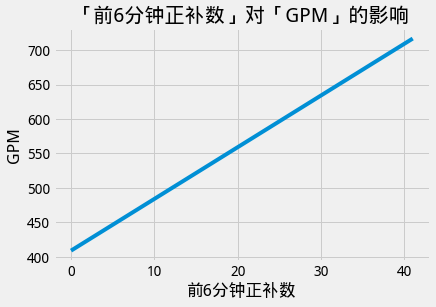

In [29]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

x = np.array(range(pa_df["the_6_min_last_hits"].min(), pa_df["the_6_min_last_hits"].max()))
plt.plot(x, model_1.params["Intercept"] + model_1.params["the_6_min_last_hits"] * x)
plt.xlabel("前6分钟正补数")
plt.ylabel("GPM")
plt.title("「前6分钟正补数」对「GPM」的影响")
plt.show()

## 控制住段位，再来看「前6分钟正补数」对「GPM」的影响

核心思想：把confounding bias控制住

In [30]:
# controls = ["party_size", "kills", "assists", "deaths"]
# controls = ["camp"]
controls = ["rank_tier"]
# controls = ["lane_role"]

model_2 = smf.ols('gold_per_min ~ the_6_min_last_hits +' + '+'.join(controls), data=rank_pa_df).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,387.9960,7.996,48.521,0.000,372.319,403.673
the_6_min_last_hits,6.9618,0.333,20.938,0.000,6.310,7.614
rank_tier,0.8429,0.125,6.768,0.000,0.599,1.087


## Regression for Dummies（哑变量）

$
E[Y_i|T_i] =  E[Y_i|T_i=0] + \beta T_i = \alpha + \beta T_i
$

In [57]:
pa_df["is_safe_lane"] = pa_df["lane_role"].apply(lambda x: 1 if x == "safe"  else 0)
pa_df

,hero_id,duration,rank_tier,party_id,party_size,creeps_stacked,camps_stacked,kills,deaths,assists,gold_per_min,total_gold,randomed,repicked,camp,hero_name,lane_role,the_6_min_last_hits,is_safe_lane
0,44,1817,None,0,1,0,0,11,3,12,667,20198,False,None,radiant,幻影刺客,safe,28,1
11,44,1793,32.0,1,1,0,0,1,2,12,367,10967,False,None,radiant,幻影刺客,safe,25,1
21,44,2482,35.0,1,2,2,1,13,8,8,461,19070,False,None,radiant,幻影刺客,safe,20,1
38,44,1430,51.0,1,5,0,0,9,0,3,672,16016,False,None,dire,幻影刺客,safe,39,1
41,44,1744,51.0,0,5,5,1,13,3,12,667,19387,False,None,radiant,幻影刺客,safe,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9042,44,2843,None,1,2,0,0,1,17,13,338,16015,False,None,radiant,幻影刺客,off,3,0
9055,44,3108,53.0,2,3,0,0,13,12,25,535,27713,False,None,dire,幻影刺客,safe,26,1
9060,44,2423,None,0,1,0,0,13,5,8,676,27299,False,None,radiant,幻影刺客,safe,28,1
9075,44,3242,None,5,1,3,2,12,10,17,602,32528,False,None,dire,幻影刺客,safe,20,1


In [60]:
smf.ols('gold_per_min ~ is_safe_lane', data=pa_df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,492.0000,13.521,36.389,0.000,465.464,518.536
is_safe_lane,77.8908,14.359,5.425,0.000,49.711,106.071


$
GPM_i = \beta_0 + \beta_1(is\_safe\_lane)_i + \beta_2 (the\_6\_min\_last\_hits)_i + e_i
$

                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             367.7007     17.284     21.274      0.000     333.780     401.621
is_safe_lane           54.1434     13.725      3.945      0.000      27.206      81.080
the_6_min_last_hits     6.8795      0.646     10.655      0.000       5.612       8.147


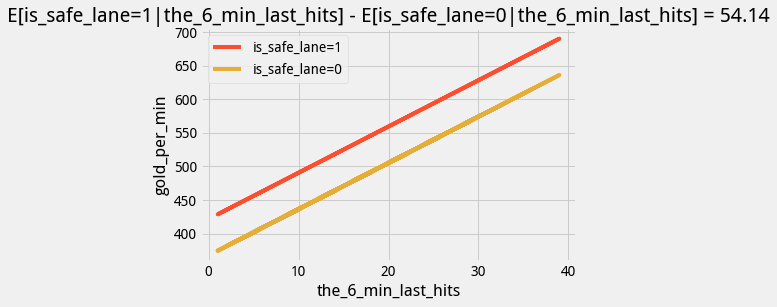

In [66]:
model = smf.ols('gold_per_min ~ is_safe_lane+the_6_min_last_hits', data=pa_df).fit()
print(model.summary().tables[1])
plt_df = pa_df.assign(y_hat = model.fittedvalues)

plt.plot(plt_df.query("is_safe_lane==1")["the_6_min_last_hits"], plt_df.query("is_safe_lane==1")["y_hat"], c="C1", label="is_safe_lane=1")
plt.plot(plt_df.query("is_safe_lane==0")["the_6_min_last_hits"], plt_df.query("is_safe_lane==0")["y_hat"], c="C2", label="is_safe_lane=0")
plt.title(f"E[is_safe_lane=1|the_6_min_last_hits] - E[is_safe_lane=0|the_6_min_last_hits] = {round(model.params['is_safe_lane'], 2)}")
plt.ylabel("gold_per_min")
plt.xlabel("the_6_min_last_hits")
plt.legend();

$
GPM_i = \beta_0 + \beta_1(is\_safe\_lane)_i + \beta_2 (the\_6\_min\_last\_hits)_i + \beta_3 (is\_safe\_lane)_i * (the\_6\_min\_last\_hits)_i + e_i
$

让线上能力强的走优势路！

                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                          381.8661     30.433     12.548      0.000     322.139     441.594
is_safe_lane                        36.3145     34.382      1.056      0.291     -31.163     103.792
the_6_min_last_hits                  6.0955      1.529      3.986      0.000       3.094       9.097
is_safe_lane:the_6_min_last_hits     0.9542      1.687      0.566      0.572      -2.357       4.265


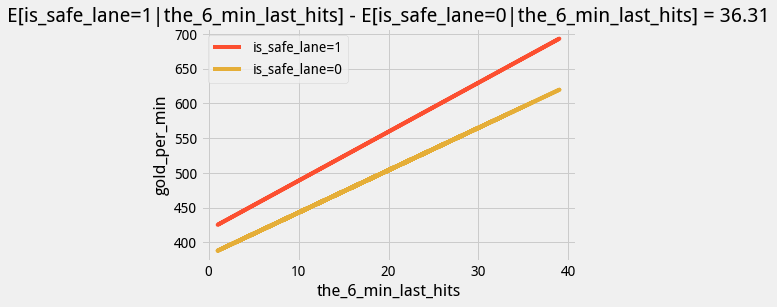

In [67]:
model = smf.ols('gold_per_min ~ is_safe_lane*the_6_min_last_hits', data=pa_df).fit()
print(model.summary().tables[1])
plt_df = pa_df.assign(y_hat = model.fittedvalues)

plt.plot(plt_df.query("is_safe_lane==1")["the_6_min_last_hits"], plt_df.query("is_safe_lane==1")["y_hat"], c="C1", label="is_safe_lane=1")
plt.plot(plt_df.query("is_safe_lane==0")["the_6_min_last_hits"], plt_df.query("is_safe_lane==0")["y_hat"], c="C2", label="is_safe_lane=0")
plt.title(f"E[is_safe_lane=1|the_6_min_last_hits] - E[is_safe_lane=0|the_6_min_last_hits] = {round(model.params['is_safe_lane'], 2)}")
plt.ylabel("gold_per_min")
plt.xlabel("the_6_min_last_hits")
plt.legend();